# Day 14 Tutorial: Dimensionality Reduction
Adapted from VanderPlas: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Up until now, we have been looking at supervised learning: training models that predict labels based on labeled training data. Here we begin looking at unsupervised learning, which can highlight interesting aspects of the data without reference to any known labels.

The most commonly used unsupervised algorithm is probably principal component analysis (PCA). PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### First let's make up some random 2-D data.

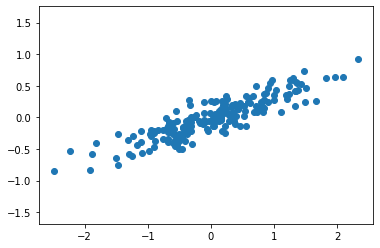

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

It is clear that there is a nearly linear relationship between the x and y variables. This is reminiscent of the linear regression data we explored in In Depth: Linear Regression, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's PCA estimator, we can compute this as follows:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [ ]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

In [ ]:
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

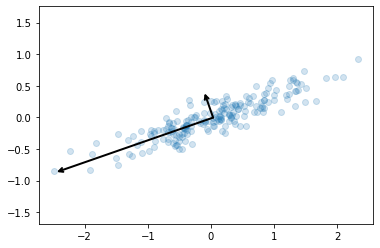

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.

## Dimensionality Reduction
Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

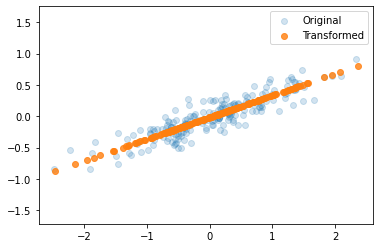

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.legend(['Original', 'Transformed'])
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## Using PCA to reduce dimensionality for higher-dimensional data
Let's make some random higher-dimensional data to try out PCA on.

Using scikit learn's make_classification function, we can make a dataset with 200 rows and 10 columns, of which 2 are genuinely useful, 5 are redundant, and 3 are just random noise.

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=200, n_features=10, n_informative=2, n_redundant=5, random_state=0)
print(X.shape, y.shape)


(200, 10) (200,)


If we use PCA to calculate the principal components, we can get a feel for how many dimensions are really present in the data, i.e, ignoring redundant or useless dimensions. The graph below shows that the first two components can explain about 80% of the variance in the data, while the rest is explained by components 3, 4, and 5. The final 5 components don't contribute anything. This makes sense because our original 10-dimensional data includes 5 redundant features.

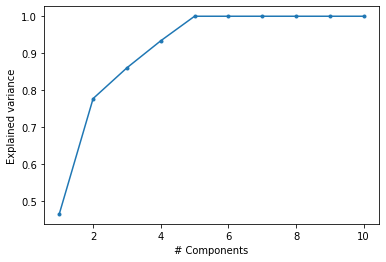

In [ ]:
pca = PCA(n_components=10)
pca.fit(X)

cs = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, 11), cs, '.-')
plt.xlabel('# Components')
plt.ylabel('Explained variance');

## PCA as preprocessing for classification
We can sometimes get improved classifier performance by using PCA to reduce the dimensionality of the data first.

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=0)
print(Xtest)

[[-1.13300321e+00  2.22241920e-01 -8.88971358e-01 -2.13239513e-01
  -5.47197753e-01  2.19123386e+00 -1.38481017e+00 -7.81016716e-01
   2.42117961e-01 -8.88720257e-01]
 [ 1.09823888e+00 -2.00063845e-01  9.30408496e-01  2.26874469e-01
   5.25045191e-01 -2.09728359e+00  1.30756012e+00  7.48555143e-01
  -1.75316402e-01 -1.42191987e+00]
 [ 3.44389870e-01 -3.37885199e-01  9.49246474e-01 -2.90332806e-01
   2.60715979e-01 -1.13627664e+00  1.03272882e+00  3.86961098e-01
  -1.50239657e+00 -1.77766695e+00]
 [-1.41560141e+00  2.26344472e-01 -2.73967717e+00 -3.33861374e-01
  -6.65759742e-01  2.64849516e+00 -1.61404831e+00 -9.47422659e-01
  -5.69312053e-01  2.69904355e-01]
 [ 1.23633363e+00 -3.45470150e-01 -6.31375988e-01  9.74235304e-02
   6.33051654e-01 -2.57016695e+00  1.74411756e+00  9.09208421e-01
  -2.41337791e-01 -8.78190343e-01]
 [-1.64679047e+00  8.70863539e-02  8.64052300e-01 -6.19900158e-01
  -7.12958435e-01  2.77450503e+00 -1.47882824e+00 -1.00465505e+00
  -2.23960406e+00  4.01499055e-01

Without dimensionality reduction, we get 86% accuracy.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)


0.86

After reducing to 2 dimensions, we get 91% accuracy by removing redundant features and reducing some of the noise from the random noise features.

In [ ]:
pca = PCA(n_components=2)
pca.fit(Xtrain)
Xtrain2 = pca.transform(Xtrain)
Xtest2 = pca.transform(Xtest)

model = KNeighborsClassifier(n_neighbors=1)
model.fit(Xtrain2, ytrain)
ypred = model.predict(Xtest2)

accuracy_score(ytest, ypred)

0.91

A scatter plot of the data projected down to the first two principal components shows that the two classes are fairly well separated.

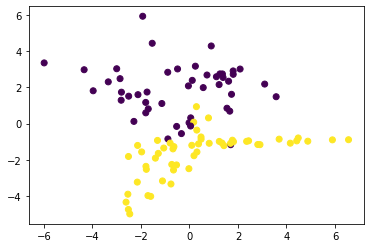

In [ ]:
plt.scatter(Xtrain2[:, 0], Xtrain2[:, 1], c=ytrain);